In [131]:
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from datetime import datetime
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torchvision.datasets import MNIST

In [132]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)

# 1 - Implement DCGAN

In [133]:
latent_dim = 100
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.fc1=nn.Linear(latent_dim,7*7*256)
    self.bn1=nn.BatchNorm1d(7*7*256)
    self.relu=nn.ReLU()
    self.deconv1=nn.ConvTranspose2d(256,128,6, stride=2, padding=2)
    self.bn2=nn.BatchNorm2d(128)
    self.deconv2=nn.ConvTranspose2d(128,32,6, stride=2, padding=2)
    self.bn3=nn.BatchNorm2d(32)
    self.deconv3=nn.ConvTranspose2d(32,1,5, stride=1, padding=2)
    self.tanh=nn.Tanh()

  def forward(self,x):
    x=self.relu(self.bn1(self.fc1(x)))
    x=x.view(-1,256,7,7)
    x=self.relu(self.bn2(self.deconv1(x)))
    x=self.relu(self.bn3(self.deconv2(x)))
    x=self.tanh(self.deconv3(x))
    return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1=nn.Conv2d(1,32,5,stride=2,padding=2)
    self.relu=nn.LeakyReLU(0.2)
    self.conv2=nn.Conv2d(32,64,5,stride=2,padding=2)
    self.bn1=nn.BatchNorm2d(64)
    self.fc1=nn.Linear(7*7*64,512)
    self.fc2=nn.Linear(512,1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    x=self.relu(self.conv1(x))
    x=self.relu(self.bn1(self.conv2(x)))
    x=x.view(-1,64*7*7)
    x1=x
    x=self.relu(self.fc1(x))
    x=self.sigmoid(self.fc2(x))

    return x, x1

# 2 - Training on MNIST

In [134]:
timestamp = (datetime.now()).strftime("%y%m%d_%H%M%S")
output_path = os.path.join("output", 'DCGAN_'+timestamp)
if not os.path.exists(output_path):
    os.makedirs(output_path)

## 2.1 - Configuration 

In [135]:
epochs=100
lr=3e-3
alpha=0.01
gamma=50
batch_size = 64
beta_1=0.5
decay=lr/epochs

## 2.2 - Load MNIST

In [136]:
print("[INFO] loading MNIST dataset...")
# Define a transform to normalize the data to the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the training and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
# Filter the training and test datasets to include only images with label 2
train_filter = train_dataset.targets == 2
test_filter = test_dataset.targets == 2
train_images = train_dataset.data[train_filter]
test_images = test_dataset.data[test_filter]
# Concatenate the training and test datasets
filtered_images = torch.cat([train_dataset.data, test_dataset.data])
# Expand dimensions to add the channel dimension and normalize
filtered_images = train_images.unsqueeze(1).float()  # Add channel dimension and convert to float
# Create a TensorDataset from the filtered images

train_loader = torch.utils.data.DataLoader(filtered_images, batch_size=batch_size, shuffle=True)
real_batch = next(iter(train_loader))

[INFO] loading MNIST dataset...


## 2.3 Initialize DCGAN

GENERATOR

In [137]:
gen=Generator().to(device)
gen.apply(weights_init)
summary(gen,(latent_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12544]       1,266,944
       BatchNorm1d-2                [-1, 12544]          25,088
              ReLU-3                [-1, 12544]               0
   ConvTranspose2d-4          [-1, 128, 14, 14]       1,179,776
       BatchNorm2d-5          [-1, 128, 14, 14]             256
              ReLU-6          [-1, 128, 14, 14]               0
   ConvTranspose2d-7           [-1, 32, 28, 28]         147,488
       BatchNorm2d-8           [-1, 32, 28, 28]              64
              ReLU-9           [-1, 32, 28, 28]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             801
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 2,620,417
Trainable params: 2,620,417
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

DISCRIMINATOR

In [138]:
discrim=Discriminator().to(device)
gen.apply(weights_init)
summary(discrim,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             832
         LeakyReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          51,264
       BatchNorm2d-4             [-1, 64, 7, 7]             128
         LeakyReLU-5             [-1, 64, 7, 7]               0
            Linear-6                  [-1, 512]       1,606,144
         LeakyReLU-7                  [-1, 512]               0
            Linear-8                    [-1, 1]             513
           Sigmoid-9                    [-1, 1]               0
Total params: 1,658,881
Trainable params: 1,658,881
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 6.33
Estimated Total Size (MB): 6.51
---------------------------------------

LOSS functions & Optimizers

In [139]:
# Loss and optimizers
criterion = nn.BCELoss().to(device)
optim_Gen = torch.optim.Adam(gen.parameters(), lr=lr)
optim_Dis = torch.optim.Adam(discrim.parameters(), lr=lr*alpha)

## 2.4 - Training

In [140]:
# Fixed noise for evaluation
noise_fixed = Variable(torch.randn((64, latent_dim))).to(device)
real_fixed = Variable(real_batch).to(device)
best_dis_loss = float('inf')

gan_loss_list, gen_loss_list, dis_loss_list = [], [], []
dis_real_list, dis_fake_list = [], []

for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        bs = data.size()[0]
        
        # Create labels 
        ones_label = Variable(torch.full((bs, 1),1.0)).to(device)
        zeros_label = Variable(torch.full((bs, 1),0.0)).to(device)
        
        real_img = Variable(data).to(device)
        noise = Variable(torch.randn(bs, latent_dim)).to(device)
        gen_img = gen(noise)
    
        # Discriminator loss
        output_real = discrim(real_img)[0]
        errD_real = criterion(output_real, ones_label)  #label smoothing to prevent discriminator becomes too confident with real images
        dis_real_list.append(errD_real.item())

        output_fake = discrim(gen_img)[0]
        errD_rec_enc = criterion(output_fake, zeros_label)
        dis_fake_list.append(errD_rec_enc.item())

        dis_loss = (errD_real + errD_rec_enc)#
      
        # Generator loss
        output_r = discrim(real_img)[1]
        output_f = discrim(gen_img)[1]
        gen_loss = ((output_r.mean(0)-output_f.mean(0))**2).mean()
        # gen_loss = criterion(output, ones_label)

        optim_Dis.zero_grad()
        optim_Gen.zero_grad()
        dis_loss.backward(retain_graph=True)
        gen_loss.backward()
        optim_Dis.step()
        optim_Gen.step()

        gen_loss_list.append(gen_loss.item())
        dis_loss_list.append(dis_loss.item())
        gan_loss_list.append(gen_loss.item()+dis_loss.item())
        
        if ((i+1) % 100 == 0) or (i == len(train_loader)-1):
            print('[%03d/%d][%d/%d]    Loss_gan: %.4f    Loss_gen: %.4f    Loss_dis: %.4f    dis_real_loss: %.4f    dis_fake_loss: %.4f'
                  % (epoch+1, epochs, i+1, len(train_loader),
                     gen_loss.item()+dis_loss.item(), gen_loss.item(), dis_loss.item(), errD_real.item(), errD_rec_enc.item()))

            # Save images
            if (epoch == 0) or ((epoch+1)%(epochs/10) == 0):
                images = gen(noise_fixed).cpu().detach().numpy()
                images = (images * 0.5 + 0.5)    # Convert from [-1, 1] to [0, 1])
                fig, axes = plt.subplots(8, 8, figsize=(8, 8))
                for i, ax in enumerate(axes.flat):
                    ax.imshow(images[i].transpose((1, 2, 0)), cmap='gray')
                    ax.axis('off')
                plt.subplots_adjust(wspace=0.1, hspace=0.1)
                plt.savefig(os.path.join(output_path, f'epoch_{epoch + 1}_output.png'), bbox_inches='tight', pad_inches=0.1)
                plt.close()
            
    # Save model if prior loss improves - choose prior loss for the generated image quality
    last_dis_loss = dis_loss_list[-1]
    if last_dis_loss < best_dis_loss:
        best_dis_loss = last_dis_loss
        torch.save({
            'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            'discrim_state_dict': discrim.state_dict(),
            'optim_Gen_state_dict': optim_Gen.state_dict(),
            'optim_Dis_state_dict': optim_Dis.state_dict(),
        }, os.path.join(output_path, 'DCGAN_best_model.pth'))

[001/100][94/94]    Loss_gan: 0.1721    Loss_gen: 0.1376    Loss_dis: 0.0344    dis_real_loss: 0.0156    dis_fake_loss: 0.0188
[002/100][94/94]    Loss_gan: 0.1066    Loss_gen: 0.0855    Loss_dis: 0.0211    dis_real_loss: 0.0111    dis_fake_loss: 0.0100
[003/100][94/94]    Loss_gan: 0.0797    Loss_gen: 0.0651    Loss_dis: 0.0146    dis_real_loss: 0.0051    dis_fake_loss: 0.0095
[004/100][94/94]    Loss_gan: 0.0986    Loss_gen: 0.0849    Loss_dis: 0.0137    dis_real_loss: 0.0072    dis_fake_loss: 0.0065
[005/100][94/94]    Loss_gan: 0.0609    Loss_gen: 0.0542    Loss_dis: 0.0067    dis_real_loss: 0.0027    dis_fake_loss: 0.0040
[006/100][94/94]    Loss_gan: 0.0859    Loss_gen: 0.0753    Loss_dis: 0.0106    dis_real_loss: 0.0059    dis_fake_loss: 0.0047
[007/100][94/94]    Loss_gan: 0.0510    Loss_gen: 0.0442    Loss_dis: 0.0069    dis_real_loss: 0.0028    dis_fake_loss: 0.0041
[008/100][94/94]    Loss_gan: 0.0387    Loss_gen: 0.0344    Loss_dis: 0.0043    dis_real_loss: 0.0026    dis_fa

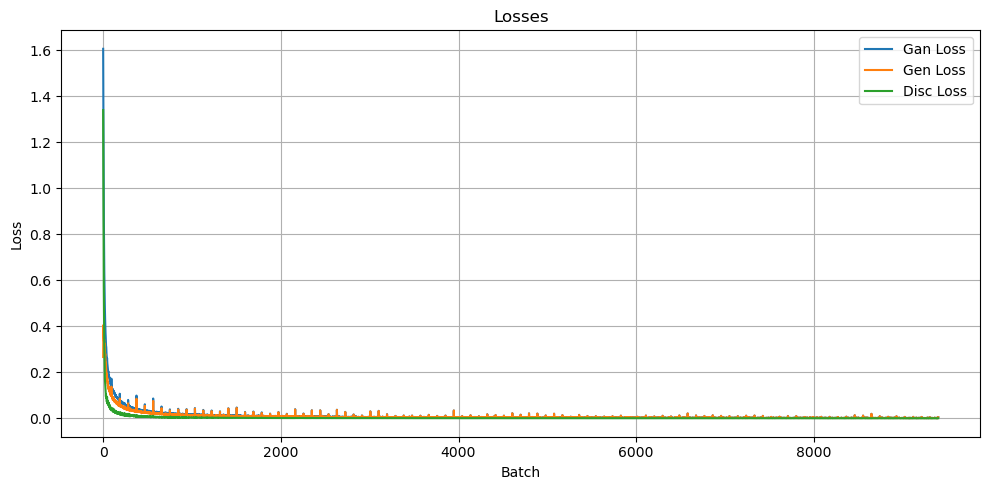

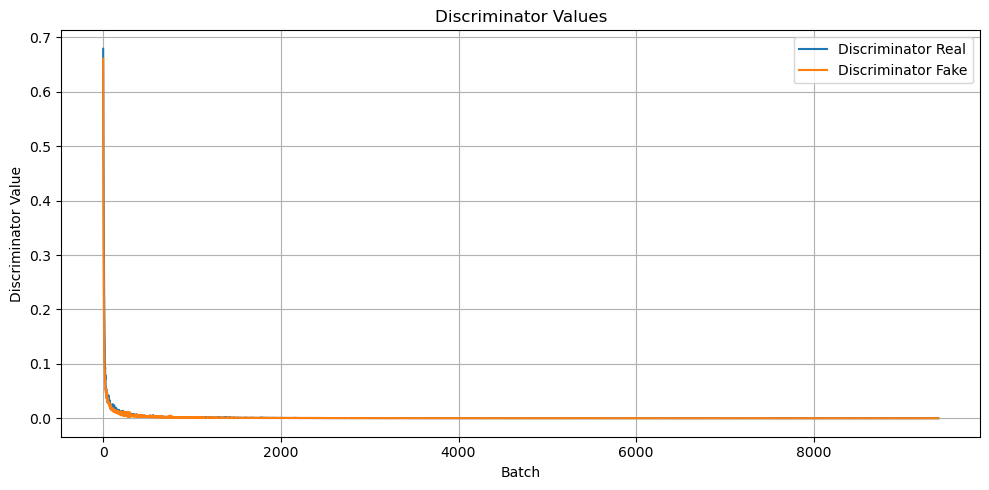

In [141]:
# First figure
plt.figure(figsize=(10, 5))
plt.plot(gan_loss_list, label='Gan Loss')
plt.plot(gen_loss_list, label='Gen Loss')
plt.plot(dis_loss_list, label='Disc Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'plot_losses.png'))
plt.show()
plt.close()

# Second figure
plt.figure(figsize=(10, 5))
plt.plot(dis_real_list, label='Discriminator Real')
plt.plot(dis_fake_list, label='Discriminator Fake')
plt.xlabel('Batch')
plt.ylabel('Discriminator Value')
plt.title('Discriminator Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'plot_discriminator_values_.png'))
plt.show()
plt.close()

In [142]:
# Define the output file path
output_file_path = os.path.join(output_path, 'losses.txt') 

# Open the file in write mode
with open(output_file_path, 'w') as f:
    f.write("gan_loss_list: " + ', '.join(map(str, gan_loss_list)) + '\n')
    f.write("gen_loss_list: " + ', '.join(map(str, gen_loss_list)) + '\n')
    f.write("dis_loss_list: " + ', '.join(map(str, dis_loss_list)) + '\n')
    f.write("dis_real_list: " + ', '.join(map(str, dis_real_list)) + '\n')
    f.write("dis_fake_list: " + ', '.join(map(str, dis_fake_list)) + '\n')

print(f"Lists have been saved to {output_file_path}")

Lists have been saved to output\DCGAN_240712_233438\losses.txt


# 3 - Test on MNIST

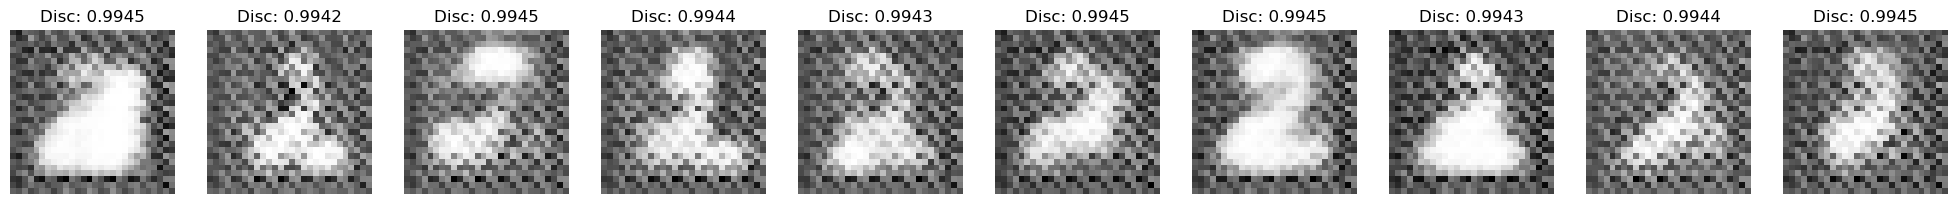

: 

In [143]:
# Load the saved model
checkpoint_path = os.path.join(output_path, 'DCGAN_best_model.pth')
checkpoint = torch.load(checkpoint_path)
gen.load_state_dict(checkpoint['gen_state_dict'])
discrim.load_state_dict(checkpoint['discrim_state_dict'])
gen.eval()
discrim.eval()

# Generate 10 images
num_images = 10
z_fixed = torch.randn(num_images, latent_dim).to(device)  # Generate random latent vectors
with torch.no_grad():
    generated_images = gen(z_fixed)
    outputs = discrim(generated_images)[0]
generated_images = (generated_images * 0.5 + 0.5)    # Convert from [-1, 1] to [0, 1])

# Plot generated images
plt.figure(figsize=(2.5*num_images, 2.5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')
    plt.title(f"Disc: {outputs[i][0]:.4f}")
    plt.axis('off')
plt.show()

